<a href="https://colab.research.google.com/github/iuricimatec/depthmap/blob/main/depthmap_stereo_cmyk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How do I extract depth from an image?
How do we estimate depth? Our eyes estimate depth by comparing the image obtained by our left and right eye. The minor displacement between both viewpoints is enough to calculate an approximate depth map. We call the pair of images obtained by our eyes a stereo pair.

if so, I must use 2 cameras to simulate such scenario. 
What's the left camera? and what's the right one?


References
https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html

https://ez.analog.com/depth-perception-ranging-technologies/lidar-solutions/3d-tof-depth-sensing/f/q-a/561113/how-to-get-a-valid-depth-map-in-python

https://github.com/analogdevicesinc/aditof_sdk/blob/master/bindings/python/examples/first_frame/first_frame.py

https://li-chongyi.github.io/proj_SR.html


https://answers.opencv.org/question/185947/how-to-resolve-a-sadwindowsize-error/


https://medium.com/yodayoda/from-depth-map-to-point-cloud-7473721d3f

In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

from PIL import Image

# to mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
pd.set_option('display.max_columns', None)

Mounted at /content/gdrive


In [2]:
# import dataset
df = pd.read_csv(
      '/content/gdrive/MyDrive/MCTI/Bolsa/dataset_skeleton.csv', index_col=0
)

In [3]:
df.count()

mark1_c1_y    3762
mark2_c1_x    3760
mark2_c1_y    3760
mark3_c1_x    3735
mark3_c1_y    3735
mark4_c1_x    3452
mark4_c1_y    3452
mark1_c2_x    3762
mark1_c2_y    3762
mark2_c2_x    3760
mark2_c2_y    3760
mark3_c2_x    3757
mark3_c2_y    3757
mark4_c2_x    3701
mark4_c2_y    3701
mark1_c3_x    3762
mark1_c3_y    3762
mark2_c3_x    3749
mark2_c3_y    3749
mark3_c3_x    3704
mark3_c3_y    3704
mark4_c3_x    3459
mark4_c3_y    3459
dtype: int64

In [4]:
# input CSV from Douglas. His code output is a CSV with tuple (x,y) for all markers. 
# how will I construct such a similar out put to match (x,y) from images and assign Z's? 
df

,mark1_c1_y,mark2_c1_x,mark2_c1_y,mark3_c1_x,mark3_c1_y,mark4_c1_x,mark4_c1_y,mark1_c2_x,mark1_c2_y,mark2_c2_x,mark2_c2_y,mark3_c2_x,mark3_c2_y,mark4_c2_x,mark4_c2_y,mark1_c3_x,mark1_c3_y,mark2_c3_x,mark2_c3_y,mark3_c3_x,mark3_c3_y,mark4_c3_x,mark4_c3_y
mark1_c1_x,,,,,,,,,,,,,,,,,,,,,,,
232,47,237.0,201.0,240.0,351.0,233.0,497.0,281,92,291.0,236.0,296.0,387.0,203.0,509.0,265,123,274.0,256.0,282.0,397.0,292.0,527.0
232,47,237.0,200.0,240.0,351.0,233.0,497.0,281,92,291.0,236.0,296.0,387.0,204.0,509.0,265,123,273.0,256.0,282.0,397.0,291.0,527.0
232,47,237.0,201.0,240.0,351.0,234.0,497.0,281,92,291.0,236.0,296.0,388.0,204.0,509.0,265,123,273.0,256.0,282.0,397.0,292.0,527.0
232,46,235.0,198.0,238.0,347.0,231.0,501.0,281,91,289.0,234.0,290.0,388.0,198.0,511.0,266,122,278.0,255.0,291.0,396.0,303.0,527.0
233,48,235.0,202.0,236.0,352.0,229.0,496.0,281,93,289.0,237.0,291.0,389.0,306.0,527.0,264,123,274.0,255.0,283.0,396.0,293.0,529.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,27,229.0,150.0,226.0,296.0,190.0,407.0,280,61,273.0,184.0,249.0,276.0,251.0,283.0,268,98,282.0,180.0,315.0,307.0,377.0,400.0
240,17,273.0,121.0,329.0,271.0,290.0,392.0,278,94,265.0,236.0,249.0,296.0,251.0,304.0,259,87,249.0,154.0,206.0,290.0,215.0,454.0
286,98,372.0,234.0,357.0,356.0,NaN,NaN,277,95,262.0,238.0,251.0,312.0,275.0,368.0,261,87,251.0,154.0,201.0,301.0,182.0,487.0


In [28]:
# Comparing an image and its neighboor of the same camera.
# Left image paths
pathL = '/content/gdrive/MyDrive/MCTI/dataset/camera1/new/'
# Right image paths
pathR = '/content/gdrive/MyDrive/MCTI/dataset/camera2/new/'
print(os.listdir(pathL))
print(os.listdir(pathR))
# Potential fix 
# os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)

filenameL = pathL + '0101.png'
filenameR = pathR + '0101.png'

['0085.png', '1288.png', '2636.png', '3312.png', '0052.png', '1505.png', '2965.png', '2018.png', '0046.png', '1539.png', '2554.png', '2024.png', '1713.png', '1908.png', '1707.png', '1934.png', '2742.png', '0250.png', '2568.png', '2030.png', '2756.png', '1061.png', '2597.png', '3110.png', '1075.png', '3448.png', '0278.png', '0287.png', '2583.png', '3104.png', '0244.png', '1920.png', '0293.png', '2540.png', '3105.png', '2233.png', '1048.png', '1935.png', '0279.png', '0292.png', '1060.png', '2582.png', '1712.png', '1074.png', '3139.png', '2541.png', '2596.png', '3111.png', '3138.png', '2569.png', '2555.png', '1706.png', '1049.png', '2226.png', '2232.png', '2227.png', '0286.png', '2743.png', '2019.png', '2031.png', '1921.png', '0090.png', '3313.png', '1909.png', '1289.png', '3475.png', '3461.png', '1510.png', '3449.png', '0084.png', '1276.png', '3307.png', '1262.png', '1538.png', '0251.png', '0245.png', '2780.png', '2757.png', '1504.png', '2025.png', '2958.png', '2794.png', '1470.png', '29

In [29]:
# reading images as RGB returns an error in the retrieve proecdure, disparity.
imgL = cv.imread(filenameL)
imgR = cv.imread(filenameR)

In [30]:
print('SizeL: ', imgL.size)
print('ShapeL: ', imgL.shape)

print('SizeR: ', imgR.size)
print('ShapeR: ', imgR.shape)


SizeL:  921600
ShapeL:  (640, 480, 3)
SizeR:  921600
ShapeR:  (640, 480, 3)


In [31]:
# Save image in GDrive
filenameL = '/content/gdrive/MyDrive/MCTI/Bolsa/RGB/0021.png'
filenameR = '/content/gdrive/MyDrive/MCTI/Bolsa/RGB/0022.png'
# saving rgb image file
cv.imwrite(filenameL,imgL)
cv.imwrite(filenameR,imgR)

True

In [32]:
# Converting to CMYK system
bgrdash_L = imgL.astype(float)/255.
K_l = 1 - np.max(bgrdash_L, axis=2)
C_l = (1-bgrdash_L[...,2] - K_l)/(1-K_l)
M_l = (1-bgrdash_L[...,1] - K_l)/(1-K_l)
Y_l = (1-bgrdash_L[...,0] - K_l)/(1-K_l)
CMYK_L = (np.dstack((C_l,M_l,Y_l,K_l)) * 255).astype(np.uint8)

<ipython-input-32-d4140bc0cd66>:4: RuntimeWarning: invalid value encountered in true_divide
  C_l = (1-bgrdash_L[...,2] - K_l)/(1-K_l)
<ipython-input-32-d4140bc0cd66>:5: RuntimeWarning: invalid value encountered in true_divide
  M_l = (1-bgrdash_L[...,1] - K_l)/(1-K_l)
<ipython-input-32-d4140bc0cd66>:6: RuntimeWarning: invalid value encountered in true_divide
  Y_l = (1-bgrdash_L[...,0] - K_l)/(1-K_l)


In [34]:
bgrdash_R = imgR.astype(float)/255.
K_r = 1 - np.max(bgrdash_R, axis=2)
C_r = (1-bgrdash_R[...,2] - K_r)/(1-K_r)
M_r = (1-bgrdash_R[...,1] - K_r)/(1-K_r)
Y_r = (1-bgrdash_R[...,0] - K_r)/(1-K_r)
CMYK_R = (np.dstack((C_r,M_r,Y_r,K_r)) * 255).astype(np.uint8)

<ipython-input-34-0ffb67f121e9>:3: RuntimeWarning: invalid value encountered in true_divide
  C_r = (1-bgrdash_R[...,2] - K_r)/(1-K_r)
<ipython-input-34-0ffb67f121e9>:4: RuntimeWarning: invalid value encountered in true_divide
  M_r = (1-bgrdash_R[...,1] - K_r)/(1-K_r)
<ipython-input-34-0ffb67f121e9>:5: RuntimeWarning: invalid value encountered in true_divide
  Y_r = (1-bgrdash_R[...,0] - K_r)/(1-K_r)


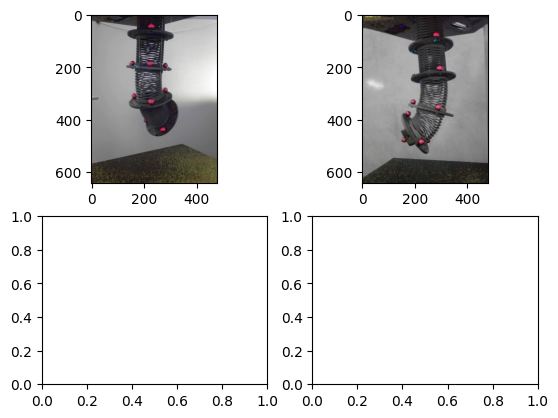

In [35]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(CMYK_L)
axarr[0,1].imshow(CMYK_R)

In [36]:
# saving CMYK image file
filenameL = '/content/gdrive/MyDrive/MCTI/Bolsa/CMYK/0021.png'
filenameR = '/content/gdrive/MyDrive/MCTI/Bolsa/CMYK/0022.png'
cv.imwrite(filenameL,CMYK_L)
cv.imwrite(filenameR,CMYK_R)

True

In [37]:
# reading CMYK from file has only 3 instead of 4 
imgL = cv.imread(filenameL)
imgR = cv.imread(filenameR)

In [38]:

print('SizeL: ', imgL.size)
print('ShapeL: ', imgL.shape)

print('SizeL: ', CMYK_L.size)
print('ShapeL: ', CMYK_L.shape)

print('SizeR: ', imgR.size)
print('ShapeR: ', imgR.shape)

print('SizeR: ', CMYK_R.size)
print('ShapeR: ', CMYK_R.shape)

SizeL:  921600
ShapeL:  (640, 480, 3)
SizeL:  1228800
ShapeL:  (640, 480, 4)
SizeR:  921600
ShapeR:  (640, 480, 3)
SizeR:  1228800
ShapeR:  (640, 480, 4)


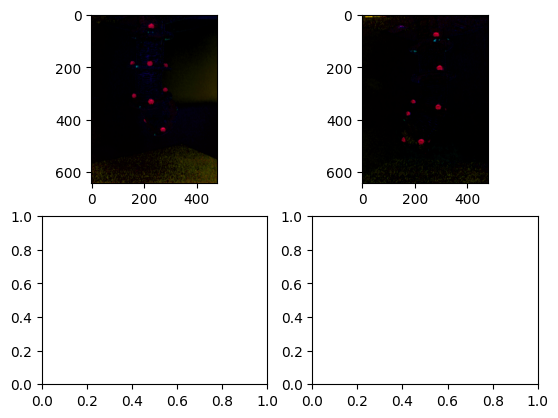

In [40]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(imgL)
axarr[0,1].imshow(imgR)

In [41]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
print(stereo)

< cv2.StereoBM 0x7fd745264710>


In [42]:
disparity = stereo.compute(imgL, imgR)
print(disparity.size)
print(disparity.shape)
print(disparity)

error: ignored

In [43]:
grayL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
grayR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

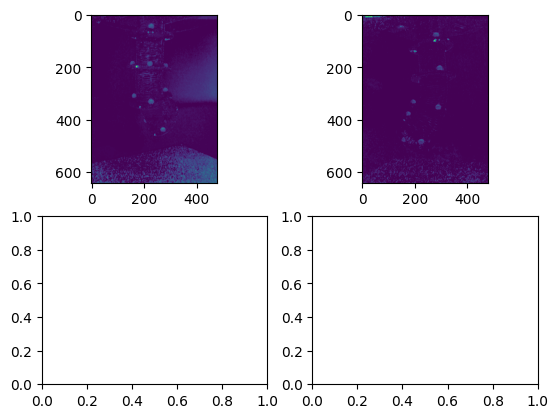

In [47]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(grayL)
axarr[0,1].imshow(grayR)

307200
(640, 480)
[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


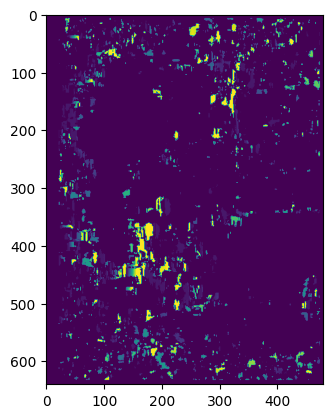

In [52]:
disparity = stereo.compute(grayL, grayR)
print(disparity.size)
print(disparity.shape)
print(disparity)
plt.imshow(disparity)

In [53]:
grayL = cv.imread(filenameL, cv.IMREAD_GRAYSCALE)
grayR = cv.imread(filenameR, cv.IMREAD_GRAYSCALE)


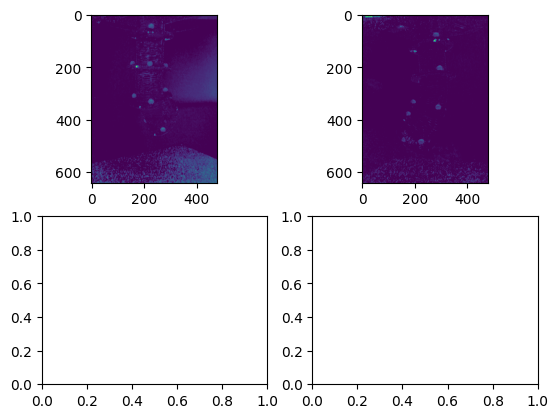

In [54]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(grayL)
axarr[0,1].imshow(grayR)

307200
(640, 480)
[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


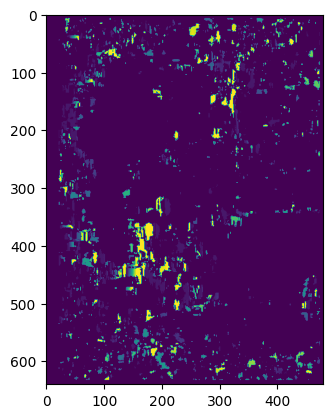

In [55]:
disparity = stereo.compute(grayL, grayR)
print(disparity.size)
print(disparity.shape)
print(disparity)
plt.imshow(disparity)

In [ ]:
# Left image paths
pathL = '/content/gdrive/MyDrive/MCTI/dataset/camera1/new/'
# Right image paths
pathR = '/content/gdrive/MyDrive/MCTI/dataset/camera3/new/'
print(os.listdir(pathL))
print(os.listdir(pathR))

# Potential fix 
# os.environ['OPENCV_IO_MAX_IMAGE_PIXELS']=str(2**64)

filenameL = pathL + '0001.png'
filenameR = pathR + '0001.png'

['0085.png', '1288.png', '2636.png', '3312.png', '0052.png', '1505.png', '2965.png', '2018.png', '0046.png', '1539.png', '2554.png', '2024.png', '1713.png', '1908.png', '1707.png', '1934.png', '2742.png', '0250.png', '2568.png', '2030.png', '2756.png', '1061.png', '2597.png', '3110.png', '1075.png', '3448.png', '0278.png', '0287.png', '2583.png', '3104.png', '0244.png', '1920.png', '0293.png', '2540.png', '3105.png', '2233.png', '1048.png', '1935.png', '0279.png', '0292.png', '1060.png', '2582.png', '1712.png', '1074.png', '3139.png', '2541.png', '2596.png', '3111.png', '3138.png', '2569.png', '2555.png', '1706.png', '1049.png', '2226.png', '2232.png', '2227.png', '0286.png', '2743.png', '2019.png', '2031.png', '1921.png', '0090.png', '3313.png', '1909.png', '1289.png', '3475.png', '3461.png', '1510.png', '3449.png', '0084.png', '1276.png', '3307.png', '1262.png', '1538.png', '0251.png', '0245.png', '2780.png', '2757.png', '1504.png', '2025.png', '2958.png', '2794.png', '1470.png', '29

In [ ]:
imgL = cv.imread(filenameL, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(filenameR, cv.IMREAD_GRAYSCALE)

print(imgL)
# print(imgR)



[[ 54  54  56 ... 169 165 171]
 [ 57  55  56 ... 168 173 172]
 [ 59  56  55 ... 169 169 170]
 ...
 [ 30  31  30 ...  29  27  26]
 [ 30  30  30 ...  28  27  25]
 [ 31  31  31 ...  29  27  25]]


In [ ]:
# cv.imshow(window_name, imgL)
# cv.imshow(window_name, imgR)
if imgL == 'None' or imgR == 'None':
  print("Image's empty!")
  print("Shapes: ", imgL.shape, imgR.shape)


<ipython-input-39-5b1ad68629a6>:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if imgL == 'None' or imgR == 'None':


In [ ]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
print(stereo)


< cv2.StereoBM 0x7ff81d52c7d0>


In [ ]:

disparity = stereo.compute(imgL,imgR)
print(disparity.size)
print(disparity.shape)
print(disparity)

307200
(640, 480)
[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


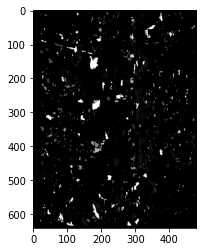

In [ ]:
plt.imshow(disparity,'gray')
# plt.imshow(disparity)
plt.show()

In [ ]:
!pip install aditofpython

import aditofpython as tof
import numpy as np

system = tof.System()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement aditofpython (from versions: none)
ERROR: No matching distribution found for aditofpython


ModuleNotFoundError: ignored

In [ ]:

#Depth
depthImage = np.array(frame.getData(tof.FrameDataType.Depth), copy=False)
depthImage = depthImage[0: frameDetails.height, 0: frameDetails.width]
print(depthImage)